# 2.機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


keras/lstm_seq2seq.py at master · keras-team/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


51から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

# Keras（文字レベル）でのシーケンスからシーケンスへの例。
このスクリプトは、基本的な文字レベルのシーケンス間モデル。の翻訳に適用します。
英語の短い文章をフランス語の短い文章に変換します。
一文字一文字。にはかなり珍しいことに注意してください。

## 文字レベルの機械翻訳を行う。
モデルの方がこの領域では一般的です。

### アルゴリズムの概要。
- あるドメイン（英語の文章など）からの入力シーケンスから開始します。
    および別のドメインからの対応する標的配列
    (フランス語の文章など)。
- エンコーダLSTMは、入力シーケンスを2つの状態ベクトルに変換します。
    (最後のLSTMの状態を保持し、出力を破棄します)。
- デコーダLSTMは，ターゲットシーケンスを
    同じシーケンスだが、将来的には1つのタイムステップだけオフセットされている。
    は，この文脈では「教師強制」と呼ばれるトレーニングプロセスです．
    これはエンコーダからの状態ベクトルを初期状態として利用する。
    事実上、デコーダは入力シーケンスに応じて `targets[t+1...t]` を生成することを学習する。
    与えられた `targets[...t]`, 入力シーケンスを条件とする.
- 推論モードでは，未知の入力シーケンスをデコードしたい場合，以下のようにする．
    - 入力シーケンスを状態ベクトルにエンコードする。
    - サイズ1のターゲットシーケンスから開始
        序の口
    - 状態ベクトルと1文字のターゲットシーケンスを与える
        をデコーダに送り、次の文字の予測値を生成します。
    - これらの予測を使用して次の文字をサンプルします。
        (ここでは単に argmax を使用しています)。
    - サンプリングした文字をターゲットシーケンスに追加します。
    - シーケンス終了文字を生成するまで繰り返します。
        文字数制限にぶつかる

**Data download**

[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)

[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)

**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)

In [ ]:
#--------------------------------------------------------------------ライブラリのimport----------------------------------------------------------------------------------

from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


#--------------------------------------------------------------------------色々定義----------------------------------------------------------------------------------------

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.（入力として使用するノードの数？）
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/Users/nobu/Desktop/fra-eng/fra.txt'


#------------------------------------------------特徴量・目的変数の文と文字を格納するものを作成-------------------------------------------------------------------

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()


#----------データから文章を読み込んで、サンプル数か文章数の少ない方の数だけ繰り返し、文章を上記texts,文字をcharactersに重複しないよう格納------

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            


#--------------------------------サンプル数、入出力時のユニークな単語数・1文の最大の単語数を算出-------------------------------------------------------------

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


#------------------------入出力データの単語とインデックスを取得、（入力データ数、1文の最大の単語数、ユニークな単語数で配列作成------------------------

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


#-----------------------------------encoder,decoderそれぞれ作成した配列の対応する部分に数値を当てはめていく-----------------------------------------

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.


#------------------------------------------------モデル構築（エンコーダ部分。入力➡︎LSTM➡︎encoder➡）----------------------------------------------------------------

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


#--------------モデル構築（デコーダー部分。初期値としてエンコーダの出力結果➡︎LSTM➡︎decoder_lstm➡︎Dence➡︎decoder_dende)---------------

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


#------------------------------------------------------------------学習&save------------------------------------------------------------------------------------

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)
# Save model
model.save('s2s.h5')


#------推論を行う部分、入力をエンコードしてデコーターの初期値を取得、初期値を用いてデコーダの1部分を行い、出力を次の入力として繰り返し------------

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

#------------------------------------------------------decodeを行い翻訳結果を返す関数------------------------------------------------------------------------------

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

#-------------------------------------------入力された文章とdecode_sequenceを通して翻訳された文章を出力---------------------------------------------------

for seq_index in range(50):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59
-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go o

# 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



In [1]:
!git clone https://github.com/pdollar/coco.git


Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [2]:
cd /content/coco/PythonAPI

/content/coco/PythonAPI


In [3]:
!make
!python setup.py build
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [4]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 3.82 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [13]:
cd /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [12]:
! unzip /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocap.zip

Archive:  /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/vocap.zip
  inflating: vocab.pkl               


In [14]:
! unzip /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip

Archive:  /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [6]:
!pip install Pillow

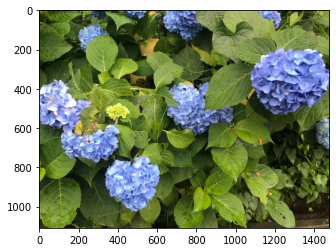

<start> a vase of flowers sitting on a table . <end>


In [17]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open('/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/2A49BAB4-A547-42DC-8B1D-8FE282676EDB.jpeg')
plt.imshow(im)
plt.show()
!python sample.py --image /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/2A49BAB4-A547-42DC-8B1D-8FE282676EDB.jpeg

➡︎机の上の花瓶

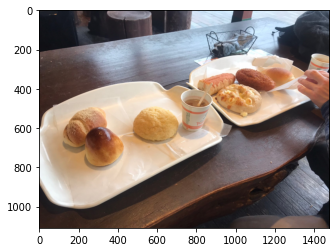

<start> a table with a sandwich and a cup of coffee . <end>


In [18]:
im = Image.open('/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/E232F6D1-6389-4903-B948-300CCFDA5F67.jpeg')
plt.imshow(im)
plt.show()
!python sample.py --image /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/E232F6D1-6389-4903-B948-300CCFDA5F67.jpeg

➡︎サンドイッチとコーヒーのあるテーブル。

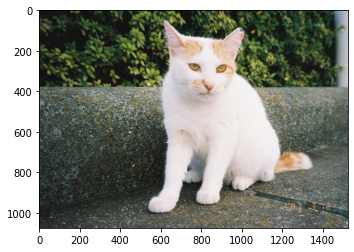

<start> a cat is sitting on a couch next to a bottle of soda . <end>


In [19]:
im = Image.open('/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/92364921-90A6-4C35-B96C-7C4FE3A75714.jpeg')
plt.imshow(im)
plt.show()
!python sample.py --image /content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/92364921-90A6-4C35-B96C-7C4FE3A75714.jpeg

➡︎猫がソーダの隣のソファに座っている

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。


https://qiita.com/lain21/items/9f9f9707ebad4bbc627d

https://qiita.com/koppe/items/7f85f5411539390c4499

```python

#pytorchで作ったモデル
model = pytorch_model()

# ONNX形式でのモデルの保存
onnx_model_path = './data/model.onnx'
dummy_input = torch.randn(1, 3, 224, 224)
input_names = ['image_array']  # ここで指定する名前が、後々saved_model.pbにする時のinput名になる
output_names = ['category']    # ここで指定する名前が、後々saved_model.pbにする時のoutput名になる

#pytorchで作ったモデルをONNX形式に変換して保存
torch.onnx.export(model, dummy_input, onnx_model_path,
                  input_names=input_names, output_names=output_names)


#ONNX形式のモデルをKerasのモデルに変換する
import onnx
from onnx2keras import onnx_to_keras

sess = tf.Session()
K.set_session(sess)

onnx_model = onnx.load('./data/model.onnx')

input_names = ['image_array']
# change_ordering=True で NCHW形式のモデルをNHWC形式のモデルに変換できる
k_model = onnx_to_keras(onnx_model=onnx_model, input_names=input_names,
                        change_ordering=True, verbose=False)

# 後々weightを再ロードするためにとっておく
weights = k_model.get_weights()
```


